# Electronic music styles Neural Net
## Walkthrough

The network architecture is similar to one, described in a paper: [AUTOMATIC TAGGING USING
DEEP CONVOLUTIONAL NEURAL NETWORKS](https://arxiv.org/pdf/1606.00298.pdf) by Keunwoochoi et al. As opposed to another architecture, described here: [Recommending music on Spotify with deep learning](http://benanne.github.io/2014/08/05/spotify-cnns.html) we found that temporal AND spectral representation gives a significantly better performance in our task. For a motivation refer to mentioned sources. However, our implementation has fewer parameters, i.e. capacity, because of lack of GPU memory to train.

In [224]:
# Necessary constants
SR = 12000
N_MELS = 96
DURA = 29.12
N_FFT = 1024
HOP_LEN = 1024
n_sample_fit = int(DURA*SR)

In [225]:
import os
import re
import shutil
import librosa
import threading
import numpy as np
import pandas as pd
import librosa.display
from mutagen.mp3 import MP3
import IPython.display as ipd
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from kapre.utils import Normalization2D
from kapre.time_frequency import Melspectrogram
from multiprocessing.dummy import Pool as ThreadPool

threads = threading.active_count() # to parallel computations

Read human-ready classes titles:

In [138]:
y_list = pd.read_csv('./keys.csv',sep=';',header=0,index_col=None)
y_list.head()

,n_labels,keys
0,Ambient / Electronic,0
1,Brostep,1
2,Deep House,2
3,Drum & Bass,3
4,EDM & Big Room,4


In [139]:
K.clear_session()
MDL_PTH = './28_mdl.h5'
mdl = load_model(MDL_PTH,
                 custom_objects={'Melspectrogram':Melspectrogram,
                                 'Normalization2D':Normalization2D})

int_axis=0 passed but is ignored, str_axis is used instead.


In [140]:
mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 349440)         0         
_________________________________________________________________
melspectrogram_1 (Melspectro (None, 96, 342, 1)        1099872   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 96, 342, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 342, 64)       640       
_________________________________________________________________
0_bn (BatchNormalization)    (None, 96, 342, 64)       256       
_________________________________________________________________
activation_0 (Activation)    (None, 96, 342, 64)       0         
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 85, 64)        0         
__________

## Audio preprocesssing and inference
Raw audio track (mp3) `file` is split by a given number of chunks `N_CHUNKS` with a fixed length of 349440 data points since audio is converted with the 12 kHz sampling rate `SR` and being a 29.12 seconds long. Before convolving there is a Melspectrogram computation layer with arguments of `N_FFT`, `HOP_LEN`, `N_MELS`, written as `keras` layer, from the library `kapre`. Then, the network is processing chunks separately, make a prediction for each of them.  At the last, a simple average probability value across all chunks is taken and sort in descending order. The reported performance with `N_CHUNKS = 10`.

In [210]:
TMP_DIR = './tmp/' # Where to write chunks of the audio track
N_CHUNKS = 10

def process_raw_audio(file,tmp_path=TMP_DIR,n_chunks = N_CHUNKS):
    """""Function is processing raw audio data (mp3) and returns an ndarray of size (N_CHUNKS, 349400)
        Only mp3 format is supported
    
    # Arguments:
        file: path to desired mp3 audio
        tmp_path: path to temp folder to keep chunks
        n_chunks: number of chunks original audio will be splitted
    
    # Return:
        numpy ndarray with given number of chunks with length of 349440 points
    
    """
    shutil.rmtree(TMP_DIR, ignore_errors=True)
    os.mkdir(TMP_DIR)

    t_duration = MP3(file).info.length
    s_split = (t_duration + 1) / n_chunks

    os.system('ffmpeg -i ' + str('"' + file + '"') + ' -nostats -loglevel 0 -vn -f segment -segment_time ' + str(s_split) + ' -ab 128k -c copy ' + tmp_path + 'chunk_%d.mp3')

    pool = ThreadPool(threads)
    R = pool.map(lambda x: librosa.load(sr=SR, path=x), [TMP_DIR + s for s in os.listdir(TMP_DIR)])
    pool.close()

    f_res = [i[0] for i in R]
    out_res = []
    for element in f_res:
        if len(element) >= int(DURA * SR):
            src = element[0:int(DURA * SR)]
        elif len(element) < int(DURA * SR):
            n_sample = len(element)
            src = np.hstack((element, np.zeros(int(DURA * SR) - n_sample)))
        out_res.append(src)

    OUTMX = np.array(out_res)
    return OUTMX

In [211]:
# SET PATH TO DESIRED MP3 AUDIO
file = './audio/glxy__the_hustle__vip.mp3'

In [212]:
X = process_raw_audio(file)
X.shape

(10, 349440)

Ok, lets listen a random chunk.

In [222]:
ind = np.random.choice(range(X.shape[0]))
ipd.Audio(X[ind],rate=SR)

And, let's see it. Compute and show melspectrogram using `librosa.display` with the same values of arguments using in the model. These are the inputs for our model.

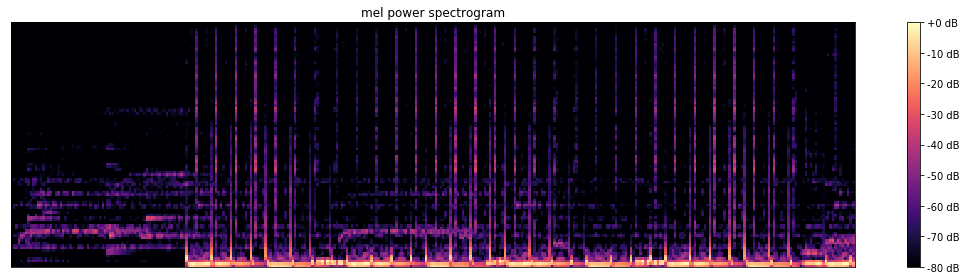

In [223]:
S = librosa.feature.melspectrogram(X[ind],sr=SR,n_mels = N_MELS, hop_length=HOP_LEN, n_fft=N_FFT, power = 2)
S = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15,4))
librosa.display.specshow(S,sr=SR)
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Now, predicting. Will output a tensor of size *(N_CHUNKS, 12)* since it's a 12 classes trained model

In [214]:
Y_hat = mdl.predict(np.expand_dims(X,1))
Y_hat.shape

(10, 12)

And, here we are

In [218]:
def get_style_title(y):
    """ Function doing routine

    # Arguments
        y: tensor, model output
        
    # Return:
        Will kindly print a top 3 electronic music style titles and their probabilites original audio belongs to, according to model
    
    """
    
    aggr = np.sum(y,axis=0) / N_CHUNKS
    style_pred = y_list.loc[np.argsort(-aggr)[0:3],['n_labels']].get_values().reshape(-1)
    probas = aggr[np.argsort(-aggr)[0:3]]
    
    print('Top first style title is %s with probability of %.3f' % (style_pred[0],probas[0]))
    print('>><<')
    print('Top second style title is %s with probability of %.3f' % (style_pred[1],probas[1]))
    print('>><<')
    print('Top third style title is %s with probability of %.3f' % (style_pred[2],probas[2]))

*Inferring a **top three** with their confidence measure* is very helpful, when model processing a crossed styles audio, that is why we evaluated perfomance in terms of *Precision @ K*. (Having a single label in train data)

In [220]:
get_style_title(Y_hat)

Top first style title is Drum & Bass with probability of 0.962
>><<
Top second style title is Progressive House with probability of 0.008
>><<
Top third style title is House / Nu Disco / Disco with probability of 0.007


The example above, a free download track of UK based duo [GLXY](https://soundcloud.com/glxymusic-1) is a pure Drum & Bass style, belongs to nu liquid funk, as the subgenre. IMO. Seeing probabilities, it's confirmed. Feel free to tag your tracks, enjoy.